<a href="https://colab.research.google.com/github/dimaakapout/MyProjects/blob/master/003_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs. Cats

В этом ноутбуке будем учиться отличать кошку от собаки

### [1. RandomForest (классическое машинное обучение)](#a001)
accuracy = 0.8765
### 2. Простая нейронная сеть
#### [2.1 Callback](#a003)
#### [2.2 Простая нейронка](#a002) 
accuracy = 0.7996
#### [2.3 Модифицированная нейронка](#a004) 
accuracy = 0.8632 (Mini-Batch normalization, ReLU)
#### [2.3 Модифицированная нейронка+](#a005) 
accuracy = 0.8875 (dropout, Xe_normal initialization, adam)
### 3. Сверточная нейронная сеть
#### [3.1 Сверточная нейронная сеть](#a006)
accuracy = 0.87
#### [3.2 Сверточная нейронная сеть+](#a007)
accuracy = 0.8875 (Mini-Batch normalization, dropout, Xe_normal initialization)
### 4. Другое
#### [4.1 Визуализация архитектуры сети в graphviz](#a008)
#### [4.2 Сохранение и загрузка архитектуры сети и весов](#a009)

In [0]:
#!pip install tensorflow==2.0.0-beta1 

In [1]:
# Import

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
import tensorflow as tf

keras = tf.keras
L = keras.layers

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
tf.__version__

'2.0.0-beta1'

In [0]:
# Загрузка данных

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


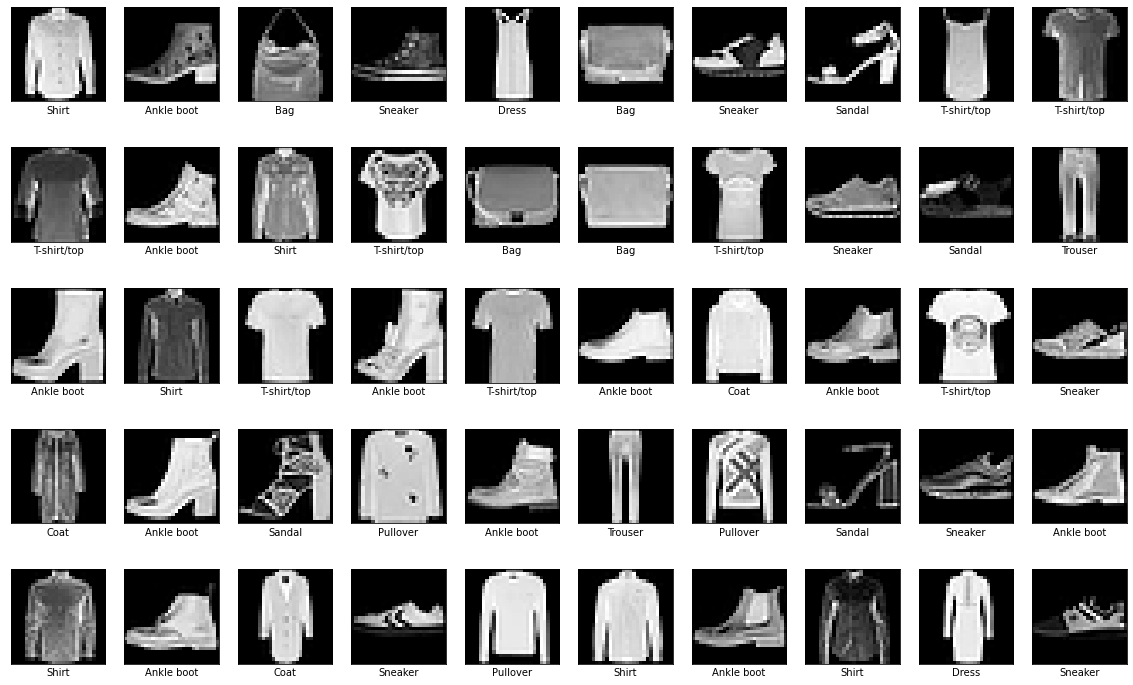

In [0]:
# Посмотрим данные

cols = 10
rows = 5
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_images[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[train_labels[random_index]])
plt.show()

In [0]:
train_images.shape, train_labels.shape, test_images.shape

((60000, 28, 28), (60000,), (10000, 28, 28))

### 1. RandomForest <a name="a001"></a>

In [0]:
rf = RandomForestClassifier()
rf.fit(train_images.reshape(60000,28**2,), train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
accuracy_score(test_labels, rf.predict(test_images.reshape(10000,28**2,)))

0.8765

`ВЫВОД:` Результат хуже, чем на MNIST (0.94), но и данные сложнее.

Попробуем решить задачу с помощью нейронныйх сетей.

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 2. Простая нейронная сеть
#### 2.1  CallBack<a name="a003"></a>

Добавим раннюю остановку в сеть

In [0]:
# Основной функционал callback

from tensorflow.keras import callbacks

class My_Callback(callbacks.Callback): # Класс My_Callback унаследовал свойства класса Callback 
    def on_train_begin(self, logs={}): # Функция, которая выполняется в начале обучения 
        return None
    def on_train_end(self, logs={}): # Функция, которая выполняется в конце обучения 
        return None
    def on_epoch_begin(self, logs={}):# В начале каждой эпохи 
        return None
    def on_epoch_end(self, epoch, logs={}): # В конце каждой эпохи 
        return None
    def on_batch_begin(self, batch, logs={}): # В начале батча 
        return None
    def on_batch_end(self, batch, logs={}): # В конце батча 
        return None

In [0]:
# Свой callback
class PrintDot(callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: 
            print('{0} эпох. acc = {1}\tval_acc = {2}'.format(epoch, logs['acc'], logs['val_acc']))
        print('.', end='')

In [0]:
# Подгружаем раннюю остановку
from keras.callbacks import EarlyStopping

# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение 8 эпох
early_stopping_monitor = EarlyStopping(patience = 10)

Using TensorFlow backend.


Зададим архитектуру нейронной сети <a name="a002"></a>

In [0]:
# Простая нейронная сеть

snn = keras.Sequential(name = 'simple_neural_network_1')
snn.add(L.Input(shape = (28,28)))
snn.add(L.Flatten())
snn.add(L.Dense(512, activation = 'tanh'))
snn.add(L.Dense(256, activation = 'tanh'))
snn.add(L.Dense(64, activation = 'tanh'))
snn.add(L.Dense(10, activation = 'softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
snn.summary()

Model: "simple_neural_network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 550,346
Trainable params: 550,346
Non-trainable params: 0
_________________________________________________________________


In [0]:
snn.compile(loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [0]:
hist_snn = snn.fit(x=train_images, y=train_labels, batch_size=10_000, epochs=100, verbose=2, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 - 2s - loss: 1.7904 - acc: 0.3538 - val_loss: 1.2069 - val_acc: 0.5474
Epoch 2/100
48000/48000 - 0s - loss: 1.1372 - acc: 0.6131 - val_loss: 0.8270 - val_acc: 0.7058
Epoch 3/100
48000/48000 - 0s - loss: 0.9088 - acc: 0.6641 - val_loss: 0.8193 - val_acc: 0.7182
Epoch 4/100
48000/48000 - 0s - loss: 0.8384 - acc: 0.6987 - val_loss: 0.8609 - val_acc: 0.7050
Epoch 5/100
48000/48000 - 0s - loss: 0.7282 - acc: 0.7306 - val_loss: 0.6537 - val_acc: 0.7392
Epoch 6/100
48000/48000 - 0s - loss: 0.6666 - acc: 0.7500 - val_loss: 0.7199 - val_acc: 0.7220
Epoch 7/100
48000/48000 - 0s - loss: 0.7714 - acc: 0.7201 - val_loss: 0.8110 - val_acc: 0.6788
Epoch 8/100
48000/48000 - 0s - loss: 0.7243 - acc: 0.7257 - val_loss: 0.5895 - val_acc: 0.7847
Epoch 9/100
48000/48000 - 0s - loss: 0.5903 - acc: 0.7836 - val_loss: 0.6387 - val_acc: 0.7648
Epoch 10/100
48000/48000 - 0s - loss: 0.6722 - acc: 0.7498 - val_loss: 0.6229 - val_acc: 0.7612

In [0]:
accuracy_score(test_labels, snn.predict_classes(test_images))

0.7996

`ВЫВОД:` Модель показала результат не лучше, чем RandomForest

In [0]:
hist_snn.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
# Визуализируем процесс обучения, напишем функцию для визуализации

def visualizer(hist):
    # hist - лог процесса обучения сетки
    fig, axes = plt.subplots(1,2, figsize = (15,6))
    axes[0].plot(hist.history['acc'], label = 'train')
    axes[0].plot(hist.history['val_acc'], label = 'test')
    axes[0].set_title('accuracy')
    axes[0].legend()
    axes[0].set_xlabel('epochs')

    axes[1].plot(hist.history['loss'],label = 'train')
    axes[1].plot(hist.history['val_loss'], label = 'test')
    axes[1].set_title('loss')
    axes[1].legend()
    axes[1].set_xlabel('epochs')

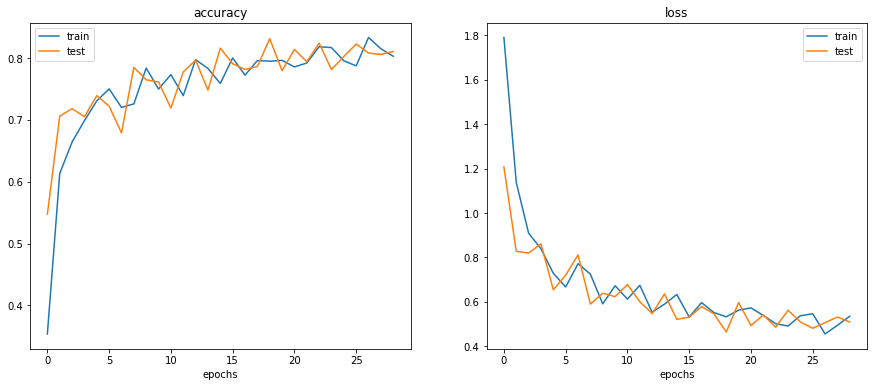

In [0]:
visualizer(hist_snn)

#### Немного модифицируем сетку <a name="a004"></a>
* Нормализуем вход на отрезок [0;1]
* Добавим mini-batch normalization
* Заменим функцию активации на ReLU

In [0]:
snn2 = keras.Sequential(name = 'simple_neural_network_2')
snn2.add(L.Input(shape = (28,28)))
snn2.add(L.Flatten())
snn2.add(L.Dense(256, activation = 'relu'))
snn2.add(L.BatchNormalization())
snn2.add(L.Dense(64, activation = 'relu'))
snn2.add(L.BatchNormalization())
snn2.add(L.Dense(10, activation = 'softmax'))

snn2.compile(loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

hist_snn2 = snn2.fit(x=train_images/255, y=train_labels, batch_size=10_000, epochs=200, verbose=0, 
        validation_split=0.2, callbacks=[early_stopping_monitor, PrintDot()])

0 эпох. acc = 0.5572291612625122	val_acc = 0.5333333611488342
..........10 эпох. acc = 0.8709999918937683	val_acc = 0.7591666579246521
..........20 эпох. acc = 0.8987500071525574	val_acc = 0.7162500023841858
..........30 эпох. acc = 0.9176458120346069	val_acc = 0.7953333258628845
..........40 эпох. acc = 0.9281250238418579	val_acc = 0.8270000219345093
..........50 эпох. acc = 0.9383124709129333	val_acc = 0.8519166707992554
..........60 эпох. acc = 0.9441458582878113	val_acc = 0.8530833125114441
..........70 эпох. acc = 0.9496458172798157	val_acc = 0.8610833287239075
......

In [0]:
accuracy_score(test_labels, snn2.predict_classes(test_images/255))

0.8632

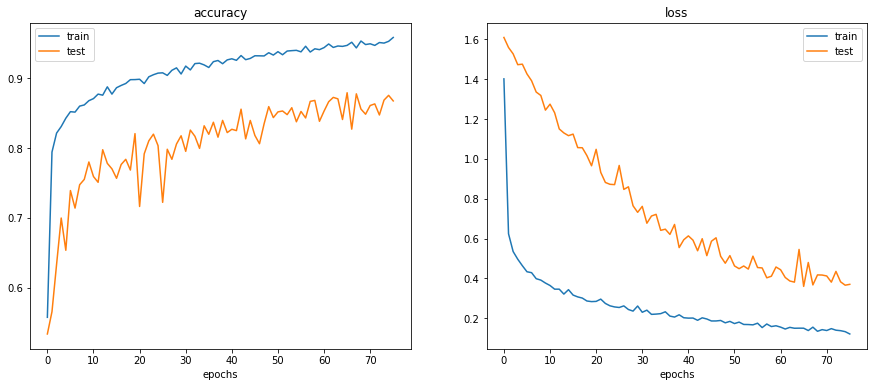

In [0]:
visualizer(hist_snn2)

`ВЫВОД:` Сетка обучается дольше, а результат точность лучше (на 2%)

#### Попробуем улучшить сеть еще <a name="a005"></a>
* Добавим dropOut
* Заменим RMSprop на adam

In [0]:
snn3 = keras.Sequential(name = 'simple_neural_network_3')
snn3.add(L.Input(shape = (28,28)))
snn3.add(L.Flatten())
snn3.add(L.Dense(256, activation = 'relu', kernel_initializer='he_normal'))
snn3.add(L.Dropout(0.2))
snn3.add(L.BatchNormalization())
snn3.add(L.Dense(64, activation = 'relu', kernel_initializer='he_normal'))
snn3.add(L.Dropout(0.2))
snn3.add(L.BatchNormalization())
snn3.add(L.Dense(10, activation = 'softmax'))

snn3.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

hist_snn3 = snn3.fit(x=train_images/255, y=train_labels, batch_size=10_000, epochs=200, verbose=0, 
        validation_split=0.2, callbacks=[early_stopping_monitor, PrintDot()])

0 эпох. acc = 0.413958340883255	val_acc = 0.503250002861023
..........10 эпох. acc = 0.8338958621025085	val_acc = 0.7980833053588867
..........20 эпох. acc = 0.8686458468437195	val_acc = 0.8607500195503235
..........30 эпох. acc = 0.8845000267028809	val_acc = 0.8742499947547913
..........40 эпох. acc = 0.8992291688919067	val_acc = 0.8830000162124634
..........50 эпох. acc = 0.9106458425521851	val_acc = 0.8841666579246521
..........60 эпох. acc = 0.9187291860580444	val_acc = 0.8919166922569275
..........70 эпох. acc = 0.9274374842643738	val_acc = 0.89041668176651
..........80 эпох. acc = 0.9341250061988831	val_acc = 0.8942499756813049
..........90 эпох. acc = 0.9396666884422302	val_acc = 0.893583357334137
....

In [0]:
accuracy_score(test_labels, snn3.predict_classes(test_images/255))

0.8875

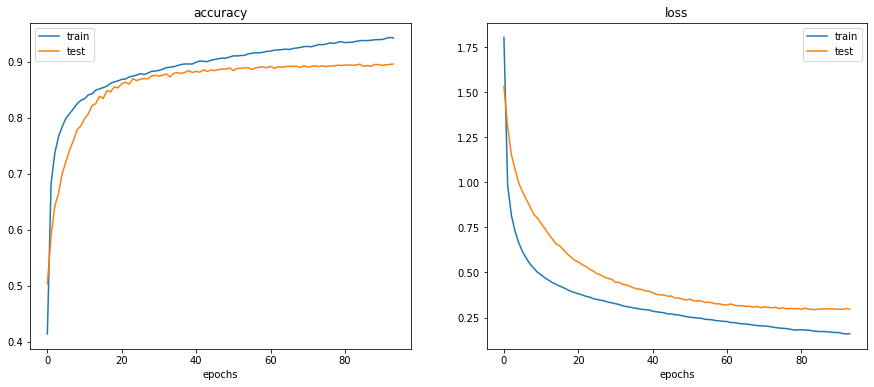

In [0]:
visualizer(hist_snn3)

`ВЫВОДы:` 
* Точность улучшилась еще на 0.5%
* Для обучения потребовалось еще больше эпох
* Поиск минимума loss выглядит достаточно гладко

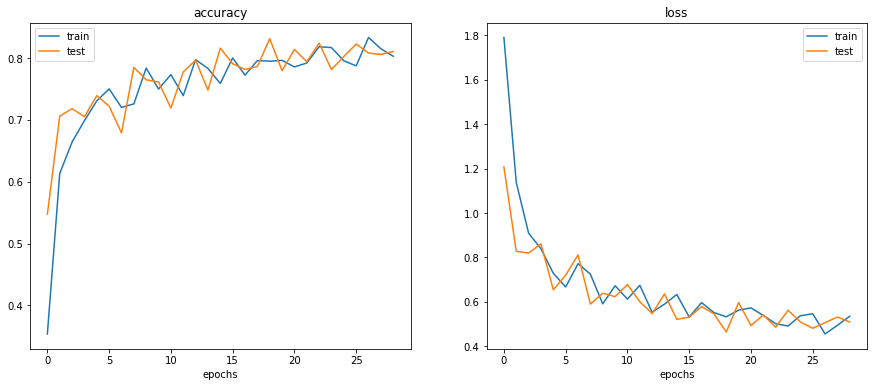

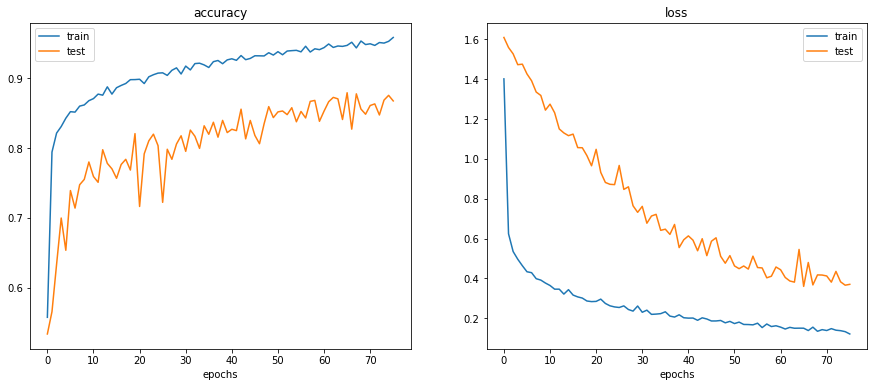

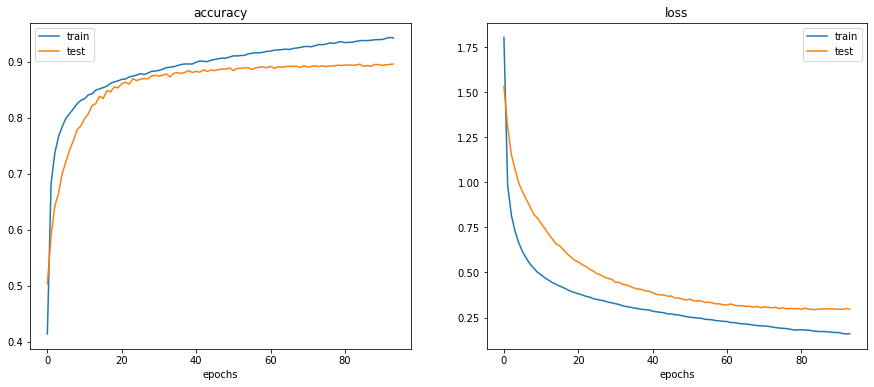

In [0]:
visualizer(hist_snn)
visualizer(hist_snn2)
visualizer(hist_snn3)

### 2. Сверточная сеть <a name="a006"></a>

Попробуем натравить сверточные сети на Fachion MNIST



In [0]:
cnn = keras.Sequential(name = 'convolution_neural_net_1')
cnn.add(L.Input(shape = (28,28,1)))
cnn.add(L.Conv2D(4, kernel_size=(5,5), activation=tf.nn.relu))
cnn.add(L.MaxPool2D(strides=(2,2)))
cnn.add(L.Conv2D(16, kernel_size=(3,3), activation=tf.nn.relu))
cnn.add(L.Flatten())
cnn.add(L.Dense(512, activation=tf.nn.relu))
cnn.add(L.Dense(128, activation=tf.nn.relu))
cnn.add(L.Dense(64, activation=tf.nn.relu))
cnn.add(L.Dense(10, activation=tf.nn.softmax))


In [0]:
cnn.summary()

Model: "convolution_neural_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        592       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               819712    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_19 (Dense)             (None, 64)   

In [0]:
cnn.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [0]:
hist_cnn = cnn.fit(x=(train_images/255)[..., np.newaxis], y=train_labels, batch_size=10_000, epochs=120, verbose=1, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/120
48000/48000 [==============================] - 6s 128us/sample - loss: 2.0037 - acc: 0.4259 - val_loss: 1.9562 - val_acc: 0.3244
Epoch 2/120
48000/48000 [==============================] - 1s 11us/sample - loss: 1.4242 - acc: 0.5369 - val_loss: 1.0906 - val_acc: 0.6244
Epoch 3/120
48000/48000 [==============================] - 1s 11us/sample - loss: 0.9264 - acc: 0.6828 - val_loss: 0.8817 - val_acc: 0.6587
Epoch 4/120
48000/48000 [==============================] - 1s 11us/sample - loss: 0.8297 - acc: 0.6962 - val_loss: 0.7625 - val_acc: 0.7135
Epoch 5/120
48000/48000 [==============================] - 1s 11us/sample - loss: 0.8001 - acc: 0.7021 - val_loss: 0.6916 - val_acc: 0.7396
Epoch 6/120
48000/48000 [==============================] - 1s 11us/sample - loss: 0.6851 - acc: 0.7414 - val_loss: 0.8005 - val_acc: 0.6847
Epoch 7/120
48000/48000 [==============================] - 1s 11us/sample - loss: 0.7204 - acc: 0.7285 - val_

In [0]:
accuracy_score(test_labels, cnn.predict_classes((test_images/255)[..., np.newaxis]))

0.87

`Выводы`
* Cущественно лучший результат получить не удалось

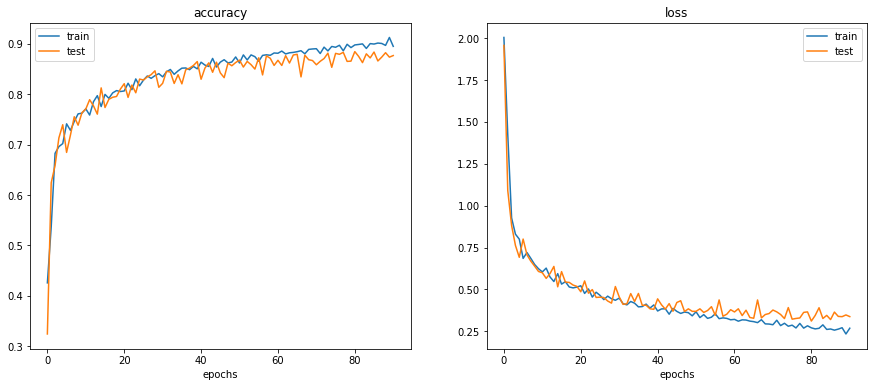

In [0]:
visualizer(hist_cnn)

**Добавим в CNN:** <a name="a007"></a>
* mini-batch normalization
* dropout
* he_normal initializations

In [0]:
cnn2 = keras.Sequential(name = 'convolution_neural_net_2')
cnn2.add(L.Input(shape = (28,28,1)))
cnn2.add(L.Conv2D(32, kernel_size=(5,5), padding='same', activation=tf.nn.relu))
cnn2.add(L.Conv2D(20, kernel_size=(3,3), padding='same', activation=tf.nn.relu))
cnn2.add(L.MaxPool2D(strides=(2,2)))
cnn2.add(L.Conv2D(16, kernel_size=(3,3), padding='same', activation=tf.nn.relu))
cnn2.add(L.Conv2D(8, kernel_size=(3,3), padding='same', activation=tf.nn.relu))
cnn2.add(L.MaxPool2D(strides=(2,2)))
cnn2.add(L.Flatten())
cnn2.add(L.Dense(128, activation=tf.nn.relu, kernel_initializer=keras.initializers.he_normal()))
cnn2.add(L.Dense(64, activation=tf.nn.relu, kernel_initializer=keras.initializers.he_normal()))
cnn2.add(L.Dense(10, activation=tf.nn.softmax))

cnn2.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [0]:
cnn2.summary()

Model: "convolution_neural_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 20)        5780      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 14, 14, 16)        2896      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 392)  

In [0]:
hist_cnn2 = cnn2.fit(x=(train_images/255)[..., np.newaxis], y=train_labels, batch_size=10_000, epochs=200, verbose=1, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 6s 133us/sample - loss: 2.1832 - acc: 0.1751 - val_loss: 1.9555 - val_acc: 0.2841
Epoch 2/200
48000/48000 [==============================] - 2s 42us/sample - loss: 1.5699 - acc: 0.4420 - val_loss: 1.0798 - val_acc: 0.6389
Epoch 3/200
48000/48000 [==============================] - 2s 42us/sample - loss: 1.1843 - acc: 0.5653 - val_loss: 1.3939 - val_acc: 0.4974
Epoch 4/200
48000/48000 [==============================] - 2s 42us/sample - loss: 0.9922 - acc: 0.6564 - val_loss: 0.9766 - val_acc: 0.6309
Epoch 5/200
48000/48000 [==============================] - 2s 42us/sample - loss: 0.9781 - acc: 0.6080 - val_loss: 0.8344 - val_acc: 0.6862
Epoch 6/200
48000/48000 [==============================] - 2s 42us/sample - loss: 0.8104 - acc: 0.7013 - val_loss: 0.9875 - val_acc: 0.6424
Epoch 7/200
48000/48000 [==============================] - 2s 42us/sample - loss: 0.8065 - acc: 0.7040 - val_

In [0]:
accuracy_score(test_labels, cnn2.predict_classes((test_images/255)[..., np.newaxis]))

0.8681

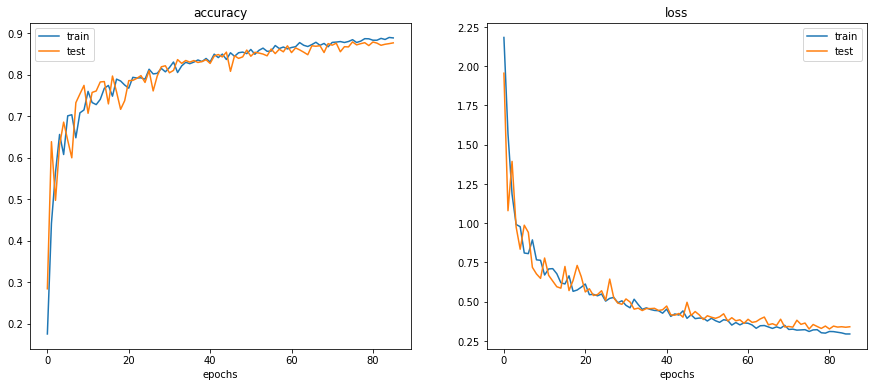

In [0]:
visualizer(hist_cnn2)

### 4.1 Визуализация архитектуры сети<a name="a008"></a>

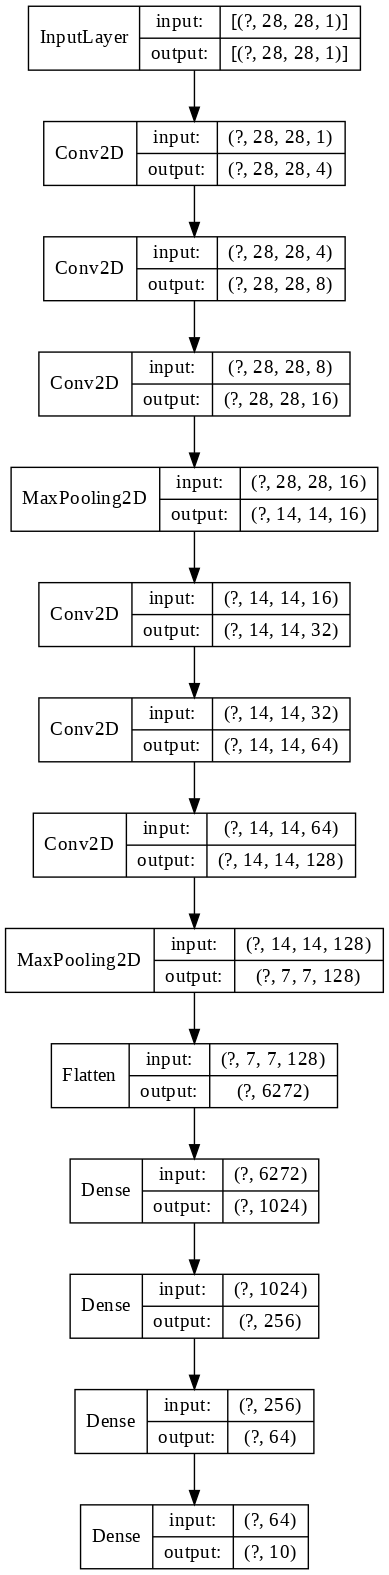

In [0]:
keras.utils.plot_model(cnn2, to_file='CNN_FM_2.png', 
                       show_shapes=True, # Показывать размерность входов и выходов слоя
                       show_layer_names = False, # Показывать имена слоев
                       dpi=100)

### 4.2 Сохранение и загрузка архитектуры сети и весов<a name="a009"></a>

Подробнее тут - https://keras.io/getting-started/faq/

In [0]:
cnn2.save('cnn2.h5') # Сохраним архитектуру модели (и веса)

In [0]:
cnn2.save_weights('cnn2_weights.h5') # Сохраним отдельно веса

In [0]:
keras.models.load_model('cnn2.h5') # Загрузка модели с весами

In [0]:
#cnn2.load_weights() # Загрузка весов, параметр by_name позволяет загружать для каждого слоя свои веса по его имени